# Resultados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

In [4]:
df = pd.read_csv('../../../Analisis_dataset/Quito/quito_2017_2018.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')

In [5]:
df = df.between_time('08:00:00','17:00:00')

In [6]:
df.head()

,RS,VEL,TMP,HUM
Date_time,,,,
2017-02-01 08:00:00,259.93,0.41,13.90,73.92
2017-02-01 09:00:00,482.96,1.02,15.77,62.89
2017-02-01 10:00:00,608.28,1.65,17.13,53.35
2017-02-01 11:00:00,789.95,2.51,17.75,47.30
2017-02-01 12:00:00,975.22,2.79,18.63,46.45


In [7]:
len_train = int(len(df)*0.8)
len_train

4120

In [8]:
df_train = df.iloc[:len_train]
df_test = df.iloc[len_train:]

## Predicciones AR

In [9]:
coef=[
    90.196831, 0.605269, -0.051036, 0.008912, -0.057670,
    0.024059, -0.014997, -0.019632, 0.053366, 0.079305,
    0.216600, -0.066506, -0.007087, -0.067058, -0.001084,
    0.022258, -0.034241, -0.038318, 0.040290, 0.028187,
    0.208899, -0.123142
]

In [10]:
len(coef)

22

In [11]:
def get_pred(coef,data):
  prediction = coef[0] # constante
  # los datos se reciben en forma cronológica
  j = 1
  for i in range(len(data)-1,-1,-1):
    prediction += coef[j] * data[i]
    j+=1
  return prediction

In [12]:
get_pred(coef,df_train['RS'][-21:].values)

309.6561112999999

In [13]:
test_pred = []
retrasos = 21

In [14]:
for i in range(retrasos,len(df_test)):
  past_data = df_test.iloc[i-retrasos:i]['RS']
  test_pred.append(get_pred(coef,past_data))

In [16]:
test_pred = np.ndarray.flatten(np.array(test_pred))
test_pred.shape

(1009,)

In [17]:
real_data = df_test.iloc[retrasos:]['RS']

In [24]:
print('RMSE:', np.sqrt(mean_squared_error(real_data,test_pred)))
print('MAE:', mean_absolute_error(real_data,test_pred))
print('R_2:', r2_score(real_data,test_pred))

RMSE: 154.58043424935263
MAE: 122.63536287757184
R_2: 0.6998072173816886


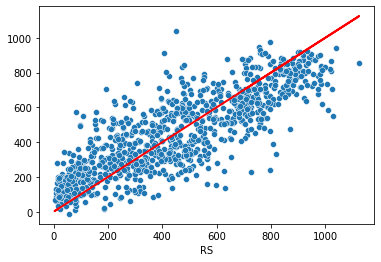

In [25]:
sns.scatterplot(x=real_data,y=test_pred)
plt.plot(real_data, real_data, linewidth=2,color="r")

In [20]:
df_predicciones = {
    'Real Data':real_data,
    'AR':test_pred
}

In [21]:
df_predicciones = pd.DataFrame(df_predicciones)

In [22]:
df_predicciones.head()

,Real Data,AR
Date_time,,
2018-03-22 09:00:00,711.31,582.186536
2018-03-22 10:00:00,913.84,783.604631
2018-03-22 11:00:00,1039.73,939.151742
2018-03-22 12:00:00,450.46,1037.348674
2018-03-22 13:00:00,760.13,504.075903


## LSTM univariado

In [27]:
best_univariado = keras.models.load_model('../../../Best_models/quito/LSTM_univariado_RS_quito.h5')

In [28]:
n_input = 20
n_features = 0

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
scaler = MinMaxScaler()
scaler.fit(df)
scaled_train = scaler.transform(df)
scaled_test = scaler.transform(df_test)

In [31]:
RS = scaled_test[:,0]

In [32]:
predictions = []
for j in range(n_input,len(RS)):
    model_input = RS[j-n_input:j]
    model_input = model_input.reshape((1, n_input, n_features+1))
    predictions.append(best_univariado.predict(model_input)[0])
predictions = np.ndarray.flatten(np.array(predictions)) 

In [33]:
len(predictions)

1010

In [34]:
test_predictions =  np.zeros(shape=(len(predictions), 4))
test_predictions[:,0] = predictions
true_predictions = scaler.inverse_transform(test_predictions)
rsg_predictions = true_predictions[:,0]

In [41]:
rsg_predictions[:5]

array([377.11078212, 587.3847765 , 816.85241892, 896.5443174 ,
       865.56971355])

In [42]:
rsg_predictions = rsg_predictions[1:]

In [43]:
df_predicciones['LSTM univariado']=rsg_predictions

In [44]:
df_predicciones.head()

,Real Data,AR,LSTM univariado
Date_time,,,
2018-03-22 09:00:00,711.31,582.186536,587.384776
2018-03-22 10:00:00,913.84,783.604631,816.852419
2018-03-22 11:00:00,1039.73,939.151742,896.544317
2018-03-22 12:00:00,450.46,1037.348674,865.569714
2018-03-22 13:00:00,760.13,504.075903,459.564110


In [45]:
print('RMSE',np.sqrt(mean_squared_error(real_data,rsg_predictions)))
print('MAE',mean_absolute_error(real_data,rsg_predictions))
print('R_2',r2_score(real_data,rsg_predictions))

RMSE 143.97858549517466
MAE 111.04565745569187
R_2 0.7395724018064762


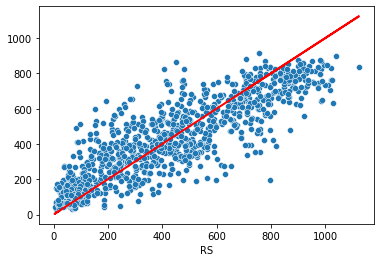

In [47]:
sns.scatterplot(x=real_data,y=rsg_predictions)
plt.plot(real_data, real_data, linewidth=2,color="r")

In [48]:
df_predicciones.to_csv('predicciones_modelos_quito.csv')